In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import madgrad
import torchsummary

In [2]:
root = 'C:/Users/kimjeongwoo2/Datasets/trump_face/'
dir_ = os.listdir(root)
img_data = list()

for img_dir in dir_:
    img_data.append(root+img_dir)
    
print('data len:'+str(len(img_data)))

data len:1709


In [3]:
class CustomDataset(Dataset):  #Dataset을 상속받아 DataLoader에서 배치 단위로 불러올 수 있게

    def __init__(self, images, transform):
        super().__init__()
        self.images = images
        self.transform = transform

    def __getitem__(self, index):
        file = self.images[index]
        img = Image.open(file).convert('RGB')
        img = self.transform(img)
        
        return img

    def __len__(self):
        return len(self.images)

In [4]:
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

In [5]:
dataset = CustomDataset(img_data, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_features=128
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), nn.Tanh())
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv(x)
        return x.view(-1, 1)

In [9]:
gen = Generator().to(device)
gen.apply(weights_init)
dis = Discriminator().to(device)
dis.apply(weights_init)
print('good')

good


In [10]:
print(gen)
torchsummary.summary(gen, (128, 1, 1))

Generator(
  (conv): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
print(dis)
torchsummary.summary(dis, (3, 64, 64))

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
------------------------------

In [12]:
g_optim = optim.Adam(gen.parameters(), lr=0.00035, betas=(0.5, 0.999))
d_optim = optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_losses = list()
d_losses = list()
images = list()
loss_fn = nn.BCELoss()

In [13]:
def noise(n, n_features=128):
    data = torch.randn(n, n_features, 1, 1)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [14]:
def train_discriminator(optimizer, real_img, fake_img):
    n = real_img.size(0)
    optimizer.zero_grad()
    prediction_real = dis(real_img)
    d_loss = loss_fn(prediction_real, label_ones(n))
    prediction_fake = dis(fake_img)
    g_loss = loss_fn(prediction_fake, label_zeros(n))
    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item()

In [15]:
def train_generator(optimizer, fake_img):
    n = fake_img.size(0)
    optimizer.zero_grad()
    prediction = dis(fake_img)
    loss = loss_fn(prediction, label_ones(n))
    loss.backward()
    optimizer.step()
    return loss.item()

In [16]:
test_noise = noise(16)
l = len(dataloader)
for epoch in range(301):
    g_loss = 0.0
    d_loss = 0.0
    for imgs in dataloader:
        n = len(imgs)
        fake_img = gen(noise(n)).detach()
        real_img = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_img, fake_img)
        fake_img = gen(noise(n))
        g_loss += train_generator(g_optim, fake_img)
        
    #img = gen(test_noise).detach().cpu()
    img = (gen(test_noise).detach().cpu()+1)/2
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)
    print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))
        
torch.save(dis.state_dict(), './models/discriminator.pth')
torch.save(gen.state_dict(), './models/generator.pth')

Epoch 0: g_loss: 10.804 d_loss: 1.159
Epoch 1: g_loss: 14.611 d_loss: 0.995
Epoch 2: g_loss: 13.872 d_loss: 1.303
Epoch 3: g_loss: 8.120 d_loss: 1.294
Epoch 4: g_loss: 5.322 d_loss: 0.958
Epoch 5: g_loss: 5.446 d_loss: 1.153
Epoch 6: g_loss: 6.213 d_loss: 1.061
Epoch 7: g_loss: 5.388 d_loss: 0.960
Epoch 8: g_loss: 5.378 d_loss: 0.717
Epoch 9: g_loss: 5.221 d_loss: 1.034
Epoch 10: g_loss: 3.967 d_loss: 0.887
Epoch 11: g_loss: 3.894 d_loss: 0.849
Epoch 12: g_loss: 4.922 d_loss: 0.783
Epoch 13: g_loss: 4.244 d_loss: 0.791
Epoch 14: g_loss: 5.252 d_loss: 0.929
Epoch 15: g_loss: 4.397 d_loss: 0.915
Epoch 16: g_loss: 4.019 d_loss: 0.753
Epoch 17: g_loss: 4.656 d_loss: 0.917
Epoch 18: g_loss: 4.708 d_loss: 0.784
Epoch 19: g_loss: 4.755 d_loss: 0.890
Epoch 20: g_loss: 4.560 d_loss: 0.816
Epoch 21: g_loss: 4.188 d_loss: 0.832
Epoch 22: g_loss: 4.183 d_loss: 0.795
Epoch 23: g_loss: 4.122 d_loss: 0.778
Epoch 24: g_loss: 4.150 d_loss: 0.823
Epoch 25: g_loss: 3.998 d_loss: 0.803
Epoch 26: g_loss: 3

In [19]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('trump_items.gif', imgs)

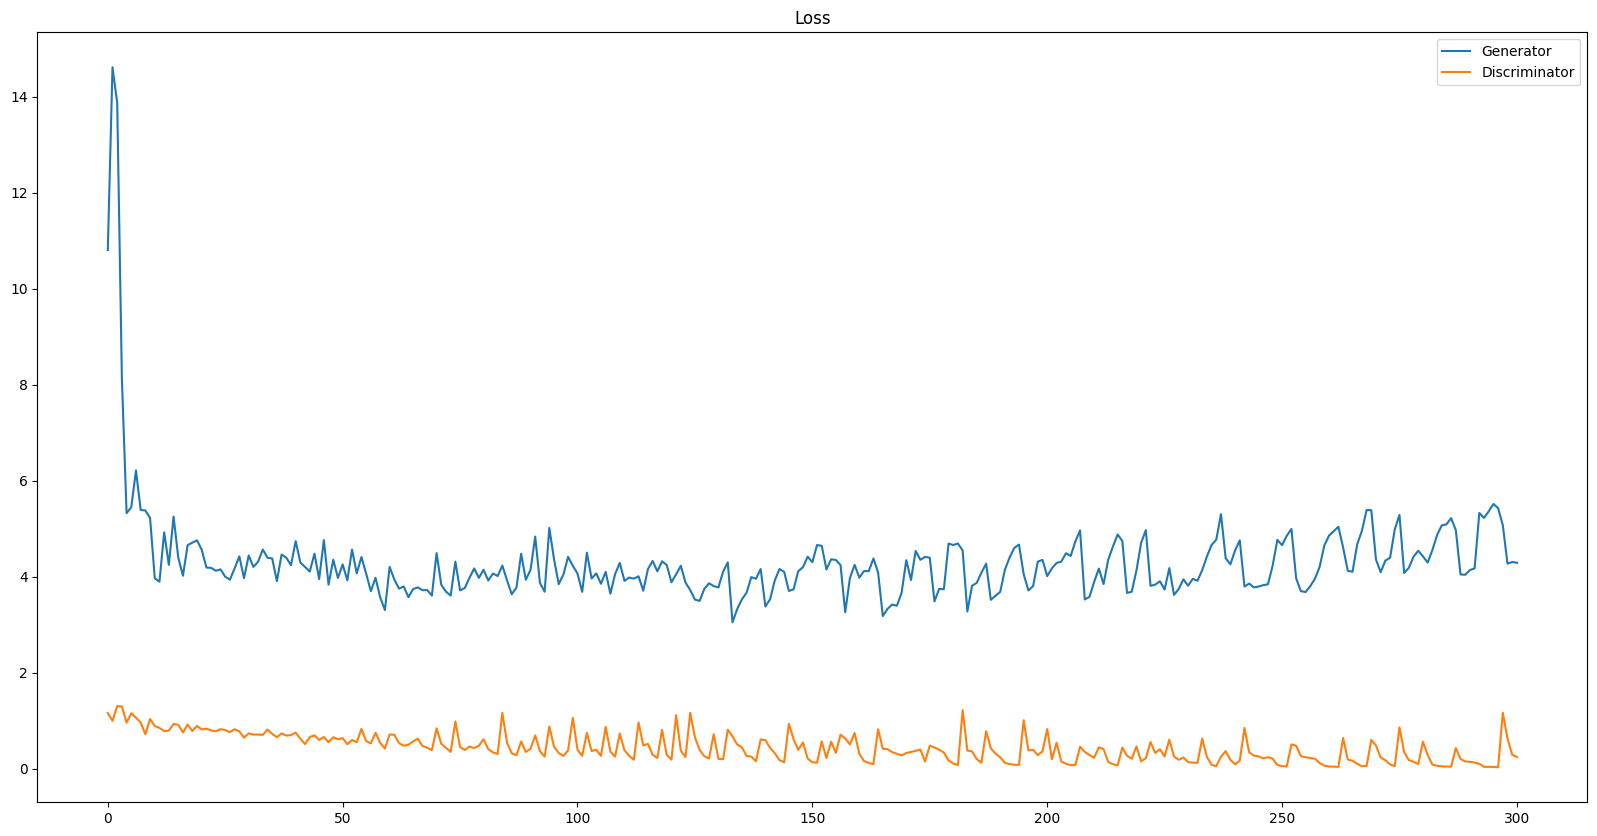

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')
plt.show()

torch.Size([64, 3, 64, 64])


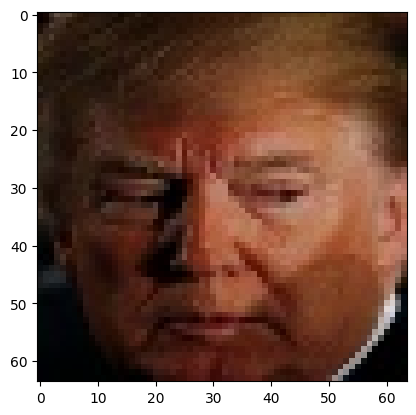

In [17]:
for img in dataloader:
    print(img.size())
    plt.imshow(((img[0].permute(1,2,0))+1)/2)
    break

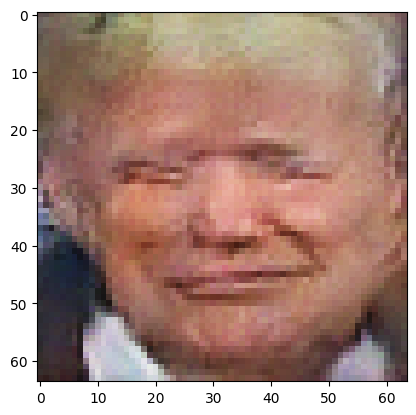

In [63]:
fake = noise(1)
plt.imshow()